In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    
    return df

#CONVERT AND RETURN NEW FILE

def import_data(file):
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
!ls /content/

application_test.csv	     installments_payments.csv
application_test.csv.zip     installments_payments.csv.zip
application_train.csv	     kaggle.json
application_train.csv.zip    POS_CASH_balance.csv
bureau_balance.csv	     POS_CASH_balance.csv.zip
bureau_balance.csv.zip	     previous_application.csv
bureau.csv		     previous_application.csv.zip
bureau.csv.zip		     sample_data
credit_card_balance.csv      sample_submission.csv
credit_card_balance.csv.zip  sample_submission.csv.zip


In [ ]:
application_train = import_data("/content/application_train.csv")

Memory usage of dataframe is 186.05 MB
Memory usage after optimization is: 45.23 MB


In [ ]:
application_test=import_data("/content/application_test.csv")

Memory usage of dataframe is 99.36 MB
Memory usage after optimization is: 26.56 MB


In [ ]:
bur_bal = import_data("/content/bureau_balance.csv")

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 202.45 MB


In [ ]:
bur = import_data("/content/bureau.csv")

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 184.00 MB


In [ ]:
credit_bal = import_data("/content/credit_card_balance.csv")

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 275.28 MB


In [ ]:
installment_payments = import_data("/content/installments_payments.csv")

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 371.61 MB


In [ ]:
pos_bal = import_data("/content/POS_CASH_balance.csv")

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 231.40 MB


In [ ]:
prev_application = import_data("/content/previous_application.csv")

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 235.95 MB


In [ ]:
gc.enable()
gc.collect()

8

In [ ]:
application_train_org = application_train.copy()

In [ ]:
print("Application Shape: ", application_train.shape)
print("Application Shape: ", application_test.shape)

Application Shape:  (199882, 122)
Application Shape:  (107629, 121)


In [ ]:
def getCnamesNumeric(df):
    return list(df.select_dtypes(exclude=['category','object']).columns)

def getCnamesObject(df):
    return list(df.select_dtypes(include=['category','object']).columns)

def getDetailsAboutMissingValuesAllColumns(df):
  return df.isna().sum()/df.shape[0]

def getDetailsAboutOnlyMissingValuesColumns(df):
  print("Shape: ", df.shape)
  return df[list(df.columns[df.isna().any()])].isna().sum()/df.shape[0]

def dropColumns(df, columnNames):
  for column in columnNames:
    df = df.drop(column, axis = 1)
  return df

def imputeCategoricalMissingValuesUsingMode(df):
  columnName = getCnamesObject(df)
  for col in columnName: df[col].fillna(df[col].mode().values[0], inplace = True)

def imputeNumericMissingValuesUsingMean(df):
  columnName = getCnamesNumeric(df)
  for col in columnName: df[col].fillna(df[col].mean(), inplace = True)

def imputeNumericMissingValuesUsingMode(df):
  columnName = getCnamesNumeric(df)
  for col in columnName: df[col].fillna(df[col].mode()[0], inplace = True)
def imputeNumericMissingValuesUsingMedian(df):
  columnName = getCnamesNumeric(df)
  for col in columnName: df[col].fillna(df[col].median(), inplace = True)



def plotCountPlotForCategoricalFeatures(df, cnamesObject):
  number_of_rows = (len(cnamesObject) + 1)/2
  plt.figure(figsize=(20, 6*number_of_rows))

  for i in range(0,len(cnamesObject)):
    plt.subplot(number_of_rows,2,i+1)
    sns.countplot(y=cnamesObject[i], data = df)
    plt.title(cnamesObject[i])
    plt.tight_layout()

def distributionOfCategoricalFeaturesWRTTarget(df, cnamesObject):
  number_of_rows = (len(cnamesObject) + 1)/2
  plt.figure(figsize=(20, 6*number_of_rows))

  for i in range(0,len(cnamesObject)):
    plt.subplot(number_of_rows,2,i+1)
    sns.countplot(data=df, hue="TARGET", y=cnamesObject[i])
    plt.title(cnamesObject[i])
    plt.tight_layout()

def drawCorrelationMatrix(df) :
  length = len(getCnamesNumeric(df))
  correlaionMatrix = df.corr()
  plt.figure(figsize=(length,length*0.8))
  sns.heatmap(correlaionMatrix, annot=True, cmap = 'viridis')

def drawDistributionPlot(df, cnamesNumeric):
  number_of_rows = (len(cnamesNumeric) + 1)/2
  plt.figure(figsize=(20, 4*number_of_rows))

  for i in range(0, len(cnamesNumeric)):
    plt.subplot(number_of_rows,3,i+1)
    sns.kdeplot(df[cnamesNumeric[i]])
    plt.title(cnamesNumeric[i])
    plt.tight_layout()

def corr_columnwise(df):
  columns = df.columns
  for col in columns:
    at_corr_col = at_corr[col]
    print(col+" +ve")
    print(at_corr_col[at_corr_col>0.9].index.to_list())
    print(col+" -ve")
    print(at_corr_col[at_corr_col<-0.9].index.to_list())

def remove_corr_columns(df,atNC,atCC,df_corr):
  threshold = 0.9
  columns = np.full((df_corr.shape[0],), True, dtype=bool)
  for i in range(df_corr.shape[0]):
      for j in range(i+1, df_corr.shape[0]):
          if df_corr.iloc[i,j] >= threshold:
              if columns[j]:
                  columns[j] = False
  x_temp=df[atNC].columns[columns].to_list()
  return pd.concat([df[x_temp],df[atCC]],axis=1)

def checkOutlier(data, cnames_numeric):
    number_of_rows = (len(cnames_numeric) + 1)/2
    plt.figure(figsize=(20, 4*number_of_rows))
    
    for i in range(0,len(cnames_numeric)):
        plt.subplot(number_of_rows,4,i+1)
        sns.boxplot(x=data[cnames_numeric[i]])
        plt.title(cnames_numeric[i])
        plt.tight_layout()

def removeOutlier(data, cnamesNumeric):
    for i in cnamesNumeric:
        q75, q25 = np.percentile(data.loc[:,i], [75 ,25])
        #Calculate IQR
        iqr = q75 - q25
        #Calculate inner and outer fence
        minimum = q25 - (iqr*1.5)
        maximum = q75 + (iqr*1.5)
        #Replace with NA
        data.loc[data.loc[:,i] < minimum,i] = np.nan
        data.loc[data.loc[:,i] > maximum,i] = np.nan
    imputeNumericMissingValuesUsingMean(data)
    return data

def drawPieChartForCategoricalFeatures(df, columnNames):
  number_of_rows = int((len(columnNames) + 1)/2)
  plt.figure(figsize=(20, 6*number_of_rows))

  for i in range(0,len(columnNames)):
    col = columnNames[i]
    percentage = (df[col].value_counts(dropna=True, normalize=True)*100).to_list()
    labels = list(df[col].unique())
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percentage)]
    sizes = list(df[col].value_counts(dropna=True))
    ax1 = plt.subplot(number_of_rows,2,i + 1)
    wedges, autotexts = ax1.pie(sizes, startangle=90)
    #ax1.axis('equal')

    ax1.legend(wedges, labels,
              title=col,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(col)
plt.show()

def applyOneHotEncoding(df, Columns):
  for col in Columns:
    ohc = OneHotEncoder()
    ohe = ohc.fit_transform(df[col].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(ohe, columns=[col+"_"+str(ohc.categories_[0][i])
                                                for i in range(len(ohc.categories_[0]))])
    df = pd.concat([df, dfOneHot.reindex(df.index)], axis=1)
    df = df.drop(col, axis = 1)
  return df
  
def plot_feature_importances(df):
    
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:10]))), df['importance_normalized'].head(10))

    ax.set_yticks(list(reversed(list(df.index[:10]))))
    ax.set_yticklabels(df['feature'].head(10))
  
    plt.xlabel('Percentage'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
def makereadyforjoin(df):
  temp = df['SK_ID_CURR']
  df=df[getCnamesNumeric(df)]
  df['SK_ID_CURR']=temp
  df=df.groupby('SK_ID_CURR').agg(['mean','max','sum','var','median'])
  df.reset_index(inplace=True)
  df.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df.columns.tolist()])
  df.rename(columns={'SK_ID_CURR_':'SK_ID_CURR'}, inplace=True)
  return df

In [ ]:
prev_application = makereadyforjoin(prev_application)

In [ ]:
credit_bal = makereadyforjoin(credit_bal)

In [ ]:
pos_bal = makereadyforjoin(pos_bal)

In [ ]:
installment_payments = makereadyforjoin(installment_payments)

In [ ]:
application_train = application_train.merge(right=prev_application, how='left', on='SK_ID_CURR')
application_test = application_test.merge(right=prev_application, how='left', on='SK_ID_CURR')

In [ ]:
application_train = application_train.merge(right=credit_bal, how='left', on='SK_ID_CURR')
application_test = application_test.merge(right=credit_bal, how='left', on='SK_ID_CURR')

In [ ]:
application_train = application_train.merge(right=pos_bal, how='left', on='SK_ID_CURR')
application_test = application_test.merge(right=pos_bal, how='left', on='SK_ID_CURR')

In [ ]:
application_train = application_train.merge(right=installment_payments, how='left', on='SK_ID_CURR')
application_test = application_test.merge(right=installment_payments, how='left', on='SK_ID_CURR')

In [ ]:
agg = {'MONTHS_BALANCE': ['min', 'max','size','mean','var','median']}
bur_bal = bur_bal.groupby('SK_ID_BUREAU').agg(agg)
bur_bal.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bur_bal.columns.tolist()])
bur_bal = bur.join(bur_bal, how='left', on='SK_ID_BUREAU')
bur_bal.drop(columns= 'SK_ID_BUREAU', inplace= True) 
temp = bur_bal['SK_ID_CURR']
bur_bal = bur_bal[getCnamesNumeric(bur_bal)]
bur_bal['SK_ID_CURR']=temp 
bur_bal = bur_bal.groupby('SK_ID_CURR').agg(['min', 'max','size','mean','var','median'])
bur_bal.reset_index(inplace=True)
bur_bal.columns = pd.Index(['BUR_' + e[0] + "_" + e[1].upper() for e in bur_bal.columns.tolist()])
bur_bal.head() 
bur_bal['SK_ID_CURR']=bur_bal['BUR_SK_ID_CURR_']
bur_bal.drop('BUR_SK_ID_CURR_',axis=1,inplace=True) 
application_train = application_train.merge(right=bur_bal, how='left', on='SK_ID_CURR')
application_test = application_test.merge(right=bur_bal, how='left', on='SK_ID_CURR') 

In [ ]:

del application_train['SK_ID_CURR']
del application_test['SK_ID_CURR']
del credit_bal
del pos_bal
del installment_payments
del prev_application
gc.enable()
gc.collect()

0

In [ ]:
application_train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,BUR_AMT_ANNUITY_SIZE,BUR_AMT_ANNUITY_MEAN,BUR_AMT_ANNUITY_VAR,BUR_AMT_ANNUITY_MEDIAN,BUR_MONTHS_BALANCE_MIN_MIN,BUR_MONTHS_BALANCE_MIN_MAX,BUR_MONTHS_BALANCE_MIN_SIZE,BUR_MONTHS_BALANCE_MIN_MEAN,BUR_MONTHS_BALANCE_MIN_VAR,BUR_MONTHS_BALANCE_MIN_MEDIAN,BUR_MONTHS_BALANCE_MAX_MIN,BUR_MONTHS_BALANCE_MAX_MAX,BUR_MONTHS_BALANCE_MAX_SIZE,BUR_MONTHS_BALANCE_MAX_MEAN,BUR_MONTHS_BALANCE_MAX_VAR,BUR_MONTHS_BALANCE_MAX_MEDIAN,BUR_MONTHS_BALANCE_SIZE_MIN,BUR_MONTHS_BALANCE_SIZE_MAX,BUR_MONTHS_BALANCE_SIZE_SIZE,BUR_MONTHS_BALANCE_SIZE_MEAN,BUR_MONTHS_BALANCE_SIZE_VAR,BUR_MONTHS_BALANCE_SIZE_MEDIAN,BUR_MONTHS_BALANCE_MEAN_MIN,BUR_MONTHS_BALANCE_MEAN_MAX,BUR_MONTHS_BALANCE_MEAN_SIZE,BUR_MONTHS_BALANCE_MEAN_MEAN,BUR_MONTHS_BALANCE_MEAN_VAR,BUR_MONTHS_BALANCE_MEAN_MEDIAN,BUR_MONTHS_BALANCE_VAR_MIN,BUR_MONTHS_BALANCE_VAR_MAX,BUR_MONTHS_BALANCE_VAR_SIZE,BUR_MONTHS_BALANCE_VAR_MEAN,BUR_MONTHS_BALANCE_VAR_VAR,BUR_MONTHS_BALANCE_VAR_MEDIAN,BUR_MONTHS_BALANCE_MEDIAN_MIN,BUR_MONTHS_BALANCE_MEDIAN_MAX,BUR_MONTHS_BALANCE_MEDIAN_SIZE,BUR_MONTHS_BALANCE_MEDIAN_MEAN,BUR_MONTHS_BALANCE_MEDIAN_VAR,BUR_MONTHS_BALANCE_MEDIAN_MEDIAN
0,0,Cash loans,M,N,Y,0,360000.0,1125000.0,33025.5,1125000.0,"Spouse, partner",Commercial associate,Higher education,Married,House / apartment,0.022797,-18943,-7369,-2352.0,-2479,NaN,1,1,0,1,0,0,Managers,2.0,2,2,WEDNESDAY,11,0,0,0,0,1,1,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,Cash loans,F,N,Y,0,112500.0,251280.0,13630.5,180000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.022629,-13894,-1393,-5696.0,-5698,NaN,1,1,0,1,0,0,Sales staff,2.0,2,2,WEDNESDAY,14,0,0,0,0,0,0,Self-employed,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
2,0,Cash loans,F,N,Y,0,225000.0,544491.0,15916.5,454500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.035797,-19821,-2075,-2120.0,-3379,NaN,1,1,1,1,0,0,Sales staff,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,Hotel,...,4.0,0.0,0.0,0.0,-91.0,-1.0,4.0,-45.75,2554.25,-45.5,-89.0,0.0,4.0,-44.0,2524.666667,-43.5,2.0,3.0,4.0,2.75,0.25,3.0,-90.0,-0.5,4.0,-44.875,2539.395833,-44.5,0.5,1.0,4.0,0.875,0.0625,1.0,-90.0,-0.5,4.0,-44.875,2539.395833,-44.5
3,0,Cash loans,F,N,N,2,211500.0,900000.0,26316.0,900000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006207,-13034,-2205,-1193.0,-4141,NaN,1,1,1,1,0,0,Laborers,4.0,2,2,THURSDAY,17,0,0,0,0,0,0,Industry: type 3,...,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
4,1,Cash loans,F,N,Y,0,90000.0,113760.0,8406.0,90000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020706,-18393,-1694,-8280.0,-1890,NaN,1,1,1,1,0,0,Sales staff,2.0,3,3,SATURDAY,12,0,0,0,0,0,0,Self-employed,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [ ]:
application_train['INCOME_CREDIT_PERC'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
application_train['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
application_train['ANNUITY_INCOME_PERC'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']
application_train['LOAN_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_train['CONSUMER_GOODS_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_GOODS_PRICE']
application_train['ANNUITY LENGTH'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY'] 

In [ ]:
application_test['INCOME_CREDIT_PERC'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_CREDIT']
application_test['INCOME_PER_PERSON'] = application_test['AMT_INCOME_TOTAL'] / application_test['CNT_FAM_MEMBERS']
application_test['ANNUITY_INCOME_PERC'] = application_test['AMT_ANNUITY'] / application_test['AMT_INCOME_TOTAL']
application_test['LOAN_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']
application_test['CONSUMER_GOODS_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_GOODS_PRICE']
application_test['ANNUITY LENGTH'] = application_test['AMT_CREDIT'] / application_test['AMT_ANNUITY'] 

In [ ]:
application_train.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,BUR_MONTHS_BALANCE_MIN_SIZE,BUR_MONTHS_BALANCE_MIN_MEAN,BUR_MONTHS_BALANCE_MIN_VAR,BUR_MONTHS_BALANCE_MIN_MEDIAN,BUR_MONTHS_BALANCE_MAX_MIN,BUR_MONTHS_BALANCE_MAX_MAX,BUR_MONTHS_BALANCE_MAX_SIZE,BUR_MONTHS_BALANCE_MAX_MEAN,BUR_MONTHS_BALANCE_MAX_VAR,BUR_MONTHS_BALANCE_MAX_MEDIAN,BUR_MONTHS_BALANCE_SIZE_MIN,BUR_MONTHS_BALANCE_SIZE_MAX,BUR_MONTHS_BALANCE_SIZE_SIZE,BUR_MONTHS_BALANCE_SIZE_MEAN,BUR_MONTHS_BALANCE_SIZE_VAR,BUR_MONTHS_BALANCE_SIZE_MEDIAN,BUR_MONTHS_BALANCE_MEAN_MIN,BUR_MONTHS_BALANCE_MEAN_MAX,BUR_MONTHS_BALANCE_MEAN_SIZE,BUR_MONTHS_BALANCE_MEAN_MEAN,BUR_MONTHS_BALANCE_MEAN_VAR,BUR_MONTHS_BALANCE_MEAN_MEDIAN,BUR_MONTHS_BALANCE_VAR_MIN,BUR_MONTHS_BALANCE_VAR_MAX,BUR_MONTHS_BALANCE_VAR_SIZE,BUR_MONTHS_BALANCE_VAR_MEAN,BUR_MONTHS_BALANCE_VAR_VAR,BUR_MONTHS_BALANCE_VAR_MEDIAN,BUR_MONTHS_BALANCE_MEDIAN_MIN,BUR_MONTHS_BALANCE_MEDIAN_MAX,BUR_MONTHS_BALANCE_MEDIAN_SIZE,BUR_MONTHS_BALANCE_MEDIAN_MEAN,BUR_MONTHS_BALANCE_MEDIAN_VAR,BUR_MONTHS_BALANCE_MEDIAN_MEDIAN,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,LOAN_INCOME_RATIO,CONSUMER_GOODS_RATIO,ANNUITY LENGTH
count,199882.000000,199882.000000,1.998820e+05,1.998820e+05,199872.000000,1.996970e+05,199882.000000,199882.000000,199882.000000,199882.0,199882.000000,68068.0,199882.0,199882.000000,199882.000000,199882.000000,199882.000000,199882.000000,199881.0,199882.000000,199882.000000,199882.000000,199882.000000,199882.000000,199882.000000,199882.000000,199882.000000,199882.000000,87079.000000,1.994560e+05,160226.000000,98267.000000,82771.000000,102235.000000,66816.000000,60065.000000,93168.000000,99131.000000,100256.000000,64099.000000,...,171265.000000,59991.000000,52097.000000,59991.000000,59991.000000,59991.000000,171265.000000,59991.000000,52097.000000,59991.000000,59991.000000,59991.000000,171265.000000,59991.000000,52097.000000,59991.000000,59991.000000,59991.000000,171265.000000,59991.000000,52097.000000,59991.000000,59833.000000,59833.000000,171265.000000,59833.000000,51896.000000,59833.000000,59991.000000,59991.000000,171265.000000,59991.000000,52097.000000,59991.000000,199882.000000,1.998810e+05,199872.000000,199882.000000,199697.000000,199872.000000
mean,0.081203,0.419447,1.687525e+05,5.996481e+05,27144.953125,5.389723e+05,0.020920,-16026.845549,63590.955214,NaN,-2992.801198,NaN,1.0,0.820514,0.199323,0.998124,0.281121,0.056518,NaN,2.051185,2.030393,12.057679,0.015149,0.051165,0.040914,0.078531,0.231006,0.179491,0.502930,NaN,NaN,0.117493,0.088684,NaN,0.752441,0.044708,0.078857,0.149780,0.226318,0.232300,...,5.560570,-34.195402,504.122704,-33.058150,-23.663466,-0.908553,5.560570,-7.732182,248.747781,-4.237711,14.430881,44.226884,5.560570,27.463219,315.545183,26.216491,-39.238852,-8.044132,5.560570,-20.963792,297.548947,-19.062655,37.787765,227.314266,5.560570,107.166074,17160.359625,90.279422,-39.238852,-8.044132,5.560570,-20.963792,297.548947,-19.062655,0.398580,9.304070e+04,0.180911,3.957618,1.122836,21.621534
std,0.273147,0.726197,1.066232e+05,4.025896e+05,14584.699219,3.697378e+05,0.013863,4363.761714,141083.570901,NaN,1507.620138,0.0,0.0,0.383760,0.399492,0.043274,0.449547,0.230921,0.0,0.509039,0.502934,3.265905,0.122145,0.220335,0.198092,0.269007,0.421477,0.383764,0.211182,0.000000e+00,0.000000,0.107483,0.082520,0.000000,0.112732,0.076172,0.134521,0.099976,0.144287,0.161255,...,4

In [ ]:
application_train=application_train.replace(np.inf, np.nan)
application_train=application_train.replace(-np.inf, np.nan)

In [ ]:
application_test=application_test.replace(np.inf, np.nan)
application_test=application_test.replace(-np.inf, np.nan)

In [ ]:
application_train_final = application_train.copy()
application_test_final = application_test.copy()

In [ ]:
application_train = application_train_final.copy()
application_test = application_test_final.copy()

In [ ]:
atCC = getCnamesObject(application_train)
print("Number of categorical columns in application_train: ", len(atCC), "\n", atCC)

atNC = getCnamesNumeric(application_train)
print("Number of numerical columns in application_train: ", len(atNC), "\n", atNC)

atestCC = getCnamesObject(application_test)
print("Number of categorical columns in application_test: ", len(atestCC), "\n", atestCC)

atestNC = getCnamesNumeric(application_test)
print("Number of numerical columns in application_test: ", len(atestNC), "\n", atestNC)

Number of categorical columns in application_train:  16 
 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Number of numerical columns in application_train:  469 
 ['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY'

In [ ]:
# atCC.remove('SK_ID_CURR')
# atestCC.remove('SK_ID_CURR')

In [ ]:
at_corr=application_train.corr()

In [ ]:
new_application_train_all_features = application_train.copy()
new_application_train = remove_corr_columns(application_train,atNC,atCC,at_corr)

In [ ]:
labels = new_application_train['TARGET']

new_application_train, new_application_test = new_application_train.align(application_test, join = 'inner', axis = 1)
new_application_train_all_features, new_application_test_all_features = new_application_train_all_features.align(application_test, join = 'inner', axis = 1)

new_application_train['TARGET'] = labels
new_application_train_all_features['TARGET'] = labels

print('Training Features shape: ', new_application_train.shape)
print('Training (all) Features shape: ', new_application_train_all_features.shape)
print('Testing Features shape: ', new_application_test.shape)


Training Features shape:  (199882, 292)
Training (all) Features shape:  (199882, 485)
Testing Features shape:  (107629, 291)


In [ ]:
# print(getDetailsAboutOnlyMissingValuesColumns(new_application_train).sort_values(ascending=False))
# print(getDetailsAboutOnlyMissingValuesColumns(new_application_test).sort_values(ascending=False))

In [ ]:
imputeCategoricalMissingValuesUsingMode(new_application_train)
imputeNumericMissingValuesUsingMedian(new_application_train)

imputeCategoricalMissingValuesUsingMode(new_application_test)
imputeNumericMissingValuesUsingMedian(new_application_test)

imputeCategoricalMissingValuesUsingMode(new_application_train_all_features)
imputeNumericMissingValuesUsingMedian(new_application_train_all_features)

imputeCategoricalMissingValuesUsingMode(new_application_test_all_features)
imputeNumericMissingValuesUsingMedian(new_application_test_all_features)

In [ ]:
# checkOutlier(new_application_train, atNC)

In [ ]:
#Extract out target variable
dfTarget = new_application_train.TARGET
new_application_train = new_application_train.drop('TARGET', axis = 1)

new_application_train_all_features = new_application_train_all_features.drop('TARGET', axis = 1)

In [ ]:
atNC = getCnamesNumeric(new_application_train)
atCC = getCnamesObject(new_application_train)

atANC = getCnamesNumeric(new_application_train_all_features)
atACC = getCnamesObject(new_application_train_all_features)

In [ ]:
# new_application_train = removeOutlier(new_application_train, atNC)

#######################Exploring Categorical Variable########################

In [ ]:
new_application_train.select_dtypes(['object','category']).apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
frequency_encoded_variables = ['OCCUPATION_TYPE','ORGANIZATION_TYPE']

In [ ]:
def frequency_encoding(variable, train, test):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [ ]:
from tqdm import tqdm

In [ ]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable, new_application_train, new_application_test)
    new_application_train[variable] = new_application_train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    new_application_test[variable] = new_application_test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))

100%|██████████| 2/2 [00:00<00:00, 51.67it/s]


In [ ]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable, new_application_train_all_features, new_application_test_all_features)
    new_application_train_all_features[variable] = new_application_train_all_features[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    new_application_test_all_features[variable] = new_application_test_all_features[variable].map(lambda x: freq_enc_dict.get(x, np.nan))

100%|██████████| 2/2 [00:00<00:00, 69.61it/s]


In [ ]:
for col in frequency_encoded_variables:
  new_application_train[col] = new_application_train[col].astype('int32')
  new_application_test[col] = new_application_test[col].astype('int32')

  new_application_train_all_features[col] = new_application_train_all_features[col].astype('int32')
  new_application_test_all_features[col] = new_application_test_all_features[col].astype('int32')

In [ ]:
atNC = getCnamesNumeric(new_application_train)
atCC = getCnamesObject(new_application_train)

atANC = getCnamesNumeric(new_application_train_all_features)
atACC = getCnamesObject(new_application_train_all_features)

In [ ]:
new_application_train=pd.get_dummies(new_application_train)
new_application_test = pd.get_dummies(new_application_test)

new_application_train_all_features=pd.get_dummies(new_application_train_all_features)
new_application_test_all_features = pd.get_dummies(new_application_test_all_features)

In [ ]:
new_application_train, new_application_test = new_application_train.align(new_application_test, join = 'inner', axis = 1)

print('Training Features shape: ', new_application_train.shape)
print('Testing Features shape: ', new_application_test.shape)

new_application_train_all_features, new_application_test_all_features = new_application_train_all_features.align(new_application_test_all_features, join = 'inner', axis = 1)

print('Training Features (all) shape: ', new_application_train_all_features.shape)
print('Testing Features (all) shape: ', new_application_test_all_features.shape)

Training Features shape:  (199882, 340)
Testing Features shape:  (107629, 340)
Training Features (all) shape:  (199882, 533)
Testing Features (all) shape:  (107629, 533)


In [ ]:
train = new_application_train.copy()
test = new_application_test.copy()
train_labels = labels.copy()
features = list(train.columns)

trainAllFt = new_application_train_all_features.copy()
testAllFt = new_application_test_all_features.copy()
train_labelsAllFt = labels.copy()
features = list(trainAllFt.columns)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train)
train = sc.transform(train)
test = sc.transform(test)

sc1 = StandardScaler()
sc1.fit(trainAllFt)
trainAllFt = sc1.transform(trainAllFt)
testAllFt = sc1.transform(testAllFt)

In [ ]:
train = pd.DataFrame(train,columns=new_application_train.columns)
test =pd.DataFrame(test,columns=new_application_test.columns)

trainAllFt = pd.DataFrame(trainAllFt,columns=new_application_train_all_features.columns)
testAllFt =pd.DataFrame(testAllFt,columns=new_application_test_all_features.columns)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
labels[labels==0].shape,labels[labels==1].shape

((183651,), (16231,))

In [ ]:
def model(features, test_features, modelType, encoding = 'ohe', n_folds = 5):
    
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features,labels):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        # model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
        #                            class_weight = 'balanced', learning_rate = 0.03,scale_pos_weight=9,
        #                            reg_alpha = 0.01, reg_lambda = 0.01, n_jobs = -1, random_state = 50)
        model = lgb.LGBMClassifier();
        if(modelType == 1): 
          model = lgb.LGBMClassifier(
                n_jobs = -1,
                n_estimators=10000,
                learning_rate=0.02,
                num_leaves=34,
                colsample_bytree=0.9497036,
                subsample=0.8715623,
                max_depth=8,
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                silent=-1,
                verbose=-1, )
        
        else: 
            model = lgb.LGBMClassifier(
                n_estimators=10000,
                learning_rate=0.03,
                num_leaves=1023,
                colsample_bytree=0.9, 
                subsample=0.8,max_depth=-1,reg_alpha=.01,reg_lambda=.01,min_child_weight=500, 
                class_weight='balanced',) 
        

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 200, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
train['TARGET'] = pd.Series(labels)
train['SK_ID_CURR'] = import_data('/content/application_train.csv').SK_ID_CURR
test['SK_ID_CURR'] = import_data('/content/application_test.csv').SK_ID_CURR

Memory usage of dataframe is 186.05 MB
Memory usage after optimization is: 45.23 MB
Memory usage of dataframe is 99.36 MB
Memory usage after optimization is: 26.56 MB


In [ ]:
trainAllFt['TARGET'] = pd.Series(labels)
trainAllFt['SK_ID_CURR'] = import_data('/content/application_train.csv').SK_ID_CURR
testAllFt['SK_ID_CURR'] = import_data('/content/application_test.csv').SK_ID_CURR

Memory usage of dataframe is 186.05 MB
Memory usage after optimization is: 45.23 MB
Memory usage of dataframe is 99.36 MB
Memory usage after optimization is: 26.56 MB


Applying Model on Dataset without correlated columns. (----M1----)

In [ ]:
submission, feature_importances, metrics = model(train, test, 1)
print(metrics)

Training Data Shape:  (199882, 340)
Testing Data Shape:  (107629, 340)
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.800893	train's binary_logloss: 0.235091	valid's auc: 0.771907	valid's binary_logloss: 0.244065
[400]	train's auc: 0.828604	train's binary_logloss: 0.223629	valid's auc: 0.782105	valid's binary_logloss: 0.239941
[600]	train's auc: 0.847116	train's binary_logloss: 0.216001	valid's auc: 0.785128	valid's binary_logloss: 0.238684
[800]	train's auc: 0.862692	train's binary_logloss: 0.209522	valid's auc: 0.786422	valid's binary_logloss: 0.238132
[1000]	train's auc: 0.875932	train's binary_logloss: 0.203757	valid's auc: 0.786889	valid's binary_logloss: 0.237899
Early stopping, best iteration is:
[980]	train's auc: 0.874636	train's binary_logloss: 0.204305	valid's auc: 0.786961	valid's binary_logloss: 0.237888
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.800691	train's binary_logloss: 0.235059	valid's au

In [ ]:
submission.to_csv('m1.csv', index = False)

------------------------M1 Done---------------------

Applying Model on Dataset all columns. (----M2----)

In [ ]:
submission, feature_importances2, metrics = model(trainAllFt, testAllFt, 1)
print(metrics)

Training Data Shape:  (199882, 533)
Testing Data Shape:  (107629, 533)
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.801787	train's binary_logloss: 0.234734	valid's auc: 0.772682	valid's binary_logloss: 0.243928
[400]	train's auc: 0.830158	train's binary_logloss: 0.223011	valid's auc: 0.782312	valid's binary_logloss: 0.239882
[600]	train's auc: 0.849616	train's binary_logloss: 0.214984	valid's auc: 0.785591	valid's binary_logloss: 0.238638
[800]	train's auc: 0.865748	train's binary_logloss: 0.208242	valid's auc: 0.786941	valid's binary_logloss: 0.238118
[1000]	train's auc: 0.879221	train's binary_logloss: 0.202272	valid's auc: 0.78756	valid's binary_logloss: 0.23788
[1200]	train's auc: 0.89097	train's binary_logloss: 0.196821	valid's auc: 0.78707	valid's binary_logloss: 0.238004
Early stopping, best iteration is:
[1054]	train's auc: 0.882462	train's binary_logloss: 0.200776	valid's auc: 0.787606	valid's binary_logloss: 0.237865
Training until valid

In [ ]:
submission.to_csv('m2.csv', index = False)

------------------------M2 Done---------------------

Applying Different Model on Dataset without correlated columns. (----M3----)

In [ ]:
submission, feature_importances, metrics = model(train, test, 2)
print(metrics)

Training Data Shape:  (199882, 340)
Testing Data Shape:  (107629, 340)
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.828416	train's binary_logloss: 0.521362	valid's auc: 0.77997	valid's binary_logloss: 0.535571
[400]	train's auc: 0.864868	train's binary_logloss: 0.477768	valid's auc: 0.784894	valid's binary_logloss: 0.507328
[600]	train's auc: 0.891422	train's binary_logloss: 0.445006	valid's auc: 0.78599	valid's binary_logloss: 0.487457
[800]	train's auc: 0.911439	train's binary_logloss: 0.417958	valid's auc: 0.786122	valid's binary_logloss: 0.470718
Early stopping, best iteration is:
[732]	train's auc: 0.905043	train's binary_logloss: 0.426687	valid's auc: 0.78641	valid's binary_logloss: 0.476021
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.829183	train's binary_logloss: 0.520289	valid's auc: 0.776724	valid's binary_logloss: 0.539003
[400]	train's auc: 0.865997	train's binary_logloss: 0.476368	valid's auc: 0

In [ ]:
submission.to_csv('m3.csv', index = False)

------------------------M3 Done---------------------

In [ ]:
m1 = pd.read_csv('m1.csv')
m2 = pd.read_csv('m2.csv')
m3 = pd.read_csv('m3.csv')

In [ ]:
submission = pd.DataFrame()
submission['SK_ID_CURR'] = m1['SK_ID_CURR']

submission['TARGET'] = 0.2 * m1['TARGET'] + 0.7 * m2['TARGET'] + 0.1 * m3['TARGET']

submission.to_csv('Elite_Model_2.csv', index = False)

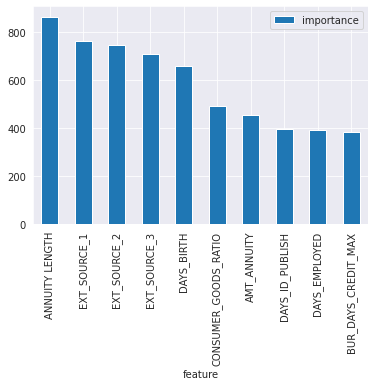

In [ ]:
feature_importances2.sort_values(by=['importance'], ascending=False).head(10).set_index('feature').plot(kind='bar')